# NOTES


### Quartz material
synthetic amorphous fused silica 

 “Fused quartz” and “fused silica” are medium refractive-index glasses containing predominately SiO2 in the amorphous (non-crystalline) form. The word quartz usually refers to the natural crystal or mineral as opposed to the phrase “fused quartz” which refers to the glass that is created out of a manufacturing process which involves heating quartz crystals to temperatures of around 2000 degrees Celsius (which has lower refractive index).

Fused quartz has better ultraviolet transmission than most other common glasses (such as borosilicate glasses that have somewhat higher refractive indices), making it an ideal candidate for applications in the sub-400nm spectral region. Additionally fused quartz/fused silica have a low thermal expansion coefficient


### TORCH Beam
The colliding-beam LHCb experiment has a forward spectrometer geometry covering ±10-300 mrad horizontally and ±10-250 mrad vertically relative to the beam axis


### ToF + ToP 
The timing information is made up of two parts, ToF & ToP. The first part is the particle time-of-flight (ToF) over a
flight path of 10 m from the LHCb interaction point (IP) to
the radiator plate. The second part is the Cherenkov photons’
time-of-propagation (ToP) in the radiator plate. The photon arrival
time is measured by micro-channel plate (MCP) sensors which is a combination of the ToF and the ToP.


Tarrival = T_0 + T_TOF + T_TOP

Where T_0 is intitial time of charged hadron emission from LHCb collision vertex


### TORCH
Per-Track time resolution of 10–15 ps is required for three sigma separation between kaons and pions.

Given about 30 photons per track [4], and assuming standard 
statistics, this leads to a required intrinsic time resolution for each photon of about 70 ps.

The size of the radiator plate is dictated by the angular acceptance of LHCb, ±0.3 rad in the horizontal plane and ±0.25 rad in the vertical plane. At the proposed downstream location at 9.5 m this would lead to a rectangular quartz plate of 5×6 m2.

The focussing block has been designed to accept θz angles between 0.45 and 0.85 rad.


With the detector plane divided vertically into 128 pixels this gives an expected resolution on θz of about 1 mrad. In the horizontal dimension, coarse pixelisation of order 6 mm (8 pixels per detector) is sufficient because there is no focussing and the photons are spread over a greater number of detectors. The error introduced in the calculation of the path length because of pixelisation results in an additional spread in the reconstructed propagation time of the photons. Initial Monte Carlo studies show this effect to be of the order of 55 ps [7].

# Simplifications

### Limit of theta z
Theta z limited to 1.55 rad as beyond this tracks are very time consuming to compute and these are quite rare angles. Will have to look into the effect of this on the results. A plot is drawn up that demonstrates the time to compute a track as a function of theta z.

In [321]:
# Dependencies
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import time
import pandas as pd

In [322]:
class EventCounter:
    def __init__(self, num_of_particles, n_cher_per_track):
        self.num_tracks_hit_radiator = 0
        self.num_photons_left_radiator = 0
        self.num_photons_left_mouth = 0
        self.num_photons_hit_mirror = 0
        self.num_photons_hit_mcp = 0
        self.num_of_particles = num_of_particles
        self.n_cher_per_track = n_cher_per_track

    def add_track(self):
        self.num_tracks_hit_radiator += 1

    def count_photons(self, photon):
        if photon.left_radiator:
            self.num_photons_left_radiator += 1
            if photon.left_mouth:
                self.num_photons_left_mouth += 1
                if photon.hit_mirror:
                    self.num_photons_hit_mirror += 1
                    if photon.hit_mcp:
                        self.num_photons_hit_mcp += 1

    def print_info(self):
        num_of_missed_tracks = self.num_of_particles - self.num_tracks_hit_radiator
        num_of_photons = self.num_tracks_hit_radiator * self.n_cher_per_track

        print("DATA CHECK MAIN")
        print(f"Number of tracks genrated: {self.num_of_particles}")
        print(f"Number of tracks hitting radiator: {self.num_tracks_hit_radiator}")
        print(f"Number of tracks missing radiator: {num_of_missed_tracks}")
        print(f"Number of expected photons on mcp: {num_of_photons}")
        print(f"Number of actual photons on mcp: {self.num_photons_hit_mcp}")

        if self.num_tracks_hit_radiator != 0:
            print(f"Percentage of photons reaching mcp: {self.num_photons_hit_mcp / num_of_photons * 100}%\n")

            print("DATA CHECK QUARTZ")
            print(f"Number of photons leaving quartz: {self.num_photons_left_radiator}")
            print(f"Percentage of photons leaving quartz: {self.num_photons_left_radiator / num_of_photons * 100}%\n")

            print("DATA CHECK FOCUSING BLOCK")
            print(f"Number of photons leaving focusing block: {self.num_photons_left_mouth}")
            print(f"Percentage of photons leaving focusing block: {self.num_photons_left_mouth / num_of_photons * 100}%\n")

            print("DATA CHECK MIRROR")
            print(f"Number of photons reaching mirror: {self.num_photons_hit_mirror}")
            print(f"Percentage of photons reaching mirror: {self.num_photons_hit_mirror / num_of_photons * 100}%\n")

            print("DATA CHECK MCP")
            print(f"Number of photons reaching MCP: {self.num_photons_hit_mcp}")
            print(f"Percentage of photons reaching MCP: {self.num_photons_hit_mcp / num_of_photons * 100}%\n")


In [323]:
# Helper functions

def set_label(ax):
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z') 

def define_quartz(quartz_params, quartz_position):    ##### SETS UP THE QUARTZ RADIATOR WITH THE SPECIFIED POSITION USED AS THE CENTRE OF THE FRONT FACE
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    
    half_quartz_width = quartz_width / 2
    half_quartz_height = quartz_height / 2
    mouth_height = 0.00878478 # 0.03 Old 3cm spec
    # Define vertices with symmetry on y and z dimensions
    Z = np.array([
        [qax, qay - half_quartz_width, qaz - half_quartz_height],
        [qax, qay - half_quartz_width, qaz + half_quartz_height + mouth_height],
        [qax, qay + half_quartz_width, qaz + half_quartz_height + mouth_height],
        [qax, qay + half_quartz_width, qaz - half_quartz_height],
        [qax + quartz_depth, qay - half_quartz_width, qaz - half_quartz_height],
        [qax + quartz_depth, qay - half_quartz_width, qaz + half_quartz_height],
        [qax + quartz_depth, qay + half_quartz_width, qaz + half_quartz_height],
        [qax + quartz_depth, qay + half_quartz_width, qaz - half_quartz_height]
    ])
    
    verts = [
        [Z[0], Z[1], Z[2], Z[3]],
        [Z[4], Z[5], Z[6], Z[7]],
        [Z[0], Z[1], Z[5], Z[4]],
        [Z[2], Z[3], Z[7], Z[6]],
        [Z[1], Z[2], Z[6], Z[5]],
        [Z[4], Z[7], Z[3], Z[0]]
    ]

    return verts

def set_detector_object_positions(quartz_params, quartz_position):
    qax, qay, qaz = quartz_position
    quartz_depth, quartz_height, quartz_width = quartz_params
    half_quartz_width = quartz_width / 2
    half_quartz_height = quartz_height / 2
    #mouth_mirror_mcp_angle = 0.85 # Radians
    mouth_height = 0.00878478 # 0.03 Old 3cm spec


    # BACK WALL OF FOCUSSING BLOCK ###
    back_coords = np.array([[qax, qay - half_quartz_width, qaz + half_quartz_height],# Bottom-left corner
                            [qax, qay + half_quartz_width, qaz + half_quartz_height], # Bottom-right corner
                            [qax, qay + half_quartz_width, qaz + half_quartz_height + mouth_height], # Top-right corner + 3cm comes from the images in forty
                            [qax, qay - half_quartz_width, qaz + half_quartz_height + mouth_height],# Top-left corner + 3cm comes from the images in forty
                            [qax, qay - half_quartz_width, qaz + half_quartz_height] # Bottom-left corner home
                            ])

    ### MOUTH OF FOCUSING BLOCK ###
    mouth_coords = np.array([[qax + quartz_depth, qay - half_quartz_width, qaz + half_quartz_height],# Bottom-left corner
                            [qax+ quartz_depth, qay + half_quartz_width, qaz + half_quartz_height], # Bottom-right corner
                            [qax, qay + half_quartz_width, qaz + half_quartz_height + mouth_height], # Top-right corner + 3cm comes from the images in forty
                            [qax, qay - half_quartz_width, qaz + half_quartz_height + mouth_height],# Top-left corner + 3cm comes from the images in forty
                            [qax+ quartz_depth, qay - half_quartz_width, qaz + half_quartz_height] # Bottom-left corner home
                            ])  
    

    # Calculate ls_coords based on the corners of back_coords and mouth_coords
    ls_coords = np.array([back_coords[0], mouth_coords[0], mouth_coords[3]])

    # Calculate rs_coords based on the corners of back_coords and mouth_coords
    rs_coords = np.array([back_coords[1], mouth_coords[1], mouth_coords[2]])

    # MIRROR
    mirror_coords = np.array([[qax + 0.12, qay - half_quartz_width, qaz + half_quartz_height + 0.08],  # Bottom-left corner   # size and position of mirror taken from forty 
                            [qax + 0.12, qay + half_quartz_width, qaz + half_quartz_height + 0.08],  # Bottom-right corner
                            [qax + 0.12 - 0.07512804, qay + half_quartz_width, qaz + half_quartz_height + 0.08 + 0.06599831],  # Top-right corner
                            [qax + 0.12 - 0.07512804, qay - half_quartz_width, qaz + half_quartz_height + 0.08 + 0.06599831],   # Top-left corner
                            [qax + 0.12, qay - half_quartz_width, qaz + half_quartz_height + 0.08]  # Bottom-left corner   # size and position of mirror taken from forty 
                            ])

    # MCP
    mcp_coords = np.array([[qax, qay - half_quartz_width, qaz + half_quartz_height + mouth_height],# Bottom-left corner
                           [qax, qay + half_quartz_width, qaz + half_quartz_height + mouth_height], # Bottom-right corner
                           [qax-0.04507682, qay + half_quartz_width, qaz + half_quartz_height + mouth_height + 0.03959899], # Top-right corner + 3cm comes from the images in forty
                           [qax-0.04507682, qay - half_quartz_width, qaz + half_quartz_height + mouth_height + 0.03959899],# Top-left corner + 3cm comes from the images in forty
                           [qax, qay - half_quartz_width, qaz + half_quartz_height + mouth_height] # Bottom-left corner home
                           ])


    return back_coords, ls_coords, rs_coords, mouth_coords, mirror_coords, mcp_coords
    

# Helper function to allow values to be input as a range from which random values are chosen each time unless the input is a single value in which case it is used as the constant value
def input_range_to_random_value(*args):
    """
    Generate random values based on input ranges or single values.

    This function accepts an arbitrary number of arguments, where each argument
    can be either a single value (int or float) or a range (list or tuple) of
    values. For ranges, it generates a random integer if the range consists of
    integers, or a random float if the range consists of floats.

    Parameters:
    *args : int, float, list, tuple
        Arbitrary number of input arguments. Each argument can be a single value
        or a range represented as a list or tuple of two values.

    Returns:
    list
        A list containing the generated random values or the input values if they
        are already single values. If an input argument is not recognized as a
        value or range, None is appended to the list and an error message is printed.
    """
    results = []

    for input_range in args:

        if isinstance(input_range, (int, float)):
            ## If input is single value it is not randomised as is manually set
            results.append(input_range)
        
        elif isinstance(input_range, (list, tuple)):
            ## If input is a list or tuple then it is considered a range of values and is randomised in that range
            
            if all(isinstance(x, int) for x in input_range):
                # If all values in the list are ints, then the whole list is considered to be a range of ints, and an int is returned
                results.append(np.random.randint(input_range[0], input_range[1] + 1))

            elif all(isinstance(x, float) for x in input_range):
                # If all values in the list are floats, then the function will return a float
                results.append(np.random.uniform(input_range[0], input_range[1]))

            else:
                print("Error: input_range_to_random_value() input is not a value or pair of values in recognised format, must be float or int")
                results.append(None)
        else:
            print("Error: input_range_to_random_value() input is not a value or pair of values")
            results.append(None)
    
    return results

In [324]:
# Visualisation functions
def visulise_tracks(sim_data):
    tracks_list, _, quartz_position, quartz_params = sim_data 
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create Quartz Radiator
    verts = define_quartz(quartz_params, quartz_position)
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.20))
    
    # Plot tracks
    for track in tracks_list:
        track_id, init_vertex, quartz_in_vtx, quartz_out_vtx = track.get_track_data()
        # stack vertices vectors together into one array 
        vertices = np.vstack((init_vertex, quartz_in_vtx, quartz_out_vtx))
        # plot track
        ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], label=f"Track {track_id}")
    set_label(ax)
    ax.set_xlim(0, qax + (quartz_depth*3))
    ax.set_ylim(-(quartz_width*1.4), qay + (quartz_width*1.4))
    ax.set_zlim(qaz-quartz_height, qaz+quartz_height)
    #plt.legend()
    plt.show()

def visulise_radiation(sim_data):
    tracks_list, cherenkov_track_list, quartz_position, quartz_params = sim_data      
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    # Create Quartz Radiator
    verts = define_quartz(quartz_params, quartz_position)
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=0.1))
    
    # plot scatter points on cherenkov photon origin verticies
    for cherenkov_track in cherenkov_track_list:
        track_id, daughter_id, reflection_vertex_list = cherenkov_track.get_track_data()
        vertex = reflection_vertex_list[0]
        #ax.scatter(vertex[0], vertex[1], vertex[2], c='g', marker='o', s=1, alpha=0.5)
        direction_vec = cherenkov_track.radiator_exit_direction_vector
        # plot line from vertex following direction vector    
        ax.plot([vertex[0], vertex[0] + (direction_vec[0]*quartz_depth)/10], 
                [vertex[1], vertex[1] + (direction_vec[1]*quartz_width)/10],
                [vertex[2], vertex[2] + (direction_vec[2]*quartz_height)/10], c='g', alpha=0.3)


    # Plot tracks
    for track in tracks_list:
        if track.track_hit_radiator:
            track_id, init_vertex, quartz_in_vtx, quartz_out_vtx = track.get_track_data()
            # mark impacts
            ax.scatter(quartz_in_vtx[0], quartz_in_vtx[1], quartz_in_vtx[2], c='r', marker='o', s=1, alpha=0.5)
            ax.scatter(quartz_out_vtx[0], quartz_out_vtx[1], quartz_out_vtx[2], c='r', marker='o', s=1, alpha=0.5)
            # plot track
            vertices = np.vstack((init_vertex, quartz_in_vtx, quartz_out_vtx))
            ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', alpha=0.4, label=f"Track {track_id}")
    set_label(ax)   
    ax.set_xlim(qax, qax + (quartz_depth))
    ax.set_ylim(qay-(quartz_width/2), qay + (quartz_width/2))
    ax.set_zlim(qaz-(quartz_height/2), qaz+(quartz_height/2))        

    plt.show()

def visulise_quartz(sim_data):  
    tracks_list, cherenkov_track_list, quartz_position, quartz_params = sim_data      
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create Quartz Radiator
    verts = define_quartz(quartz_params, quartz_position)
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=1, edgecolors='r', alpha=.20))
    


    # Plot tracks
    for track in tracks_list:
        if track.track_hit_radiator:
            track_id, init_vertex, quartz_in_vtx, quartz_out_vtx = track.get_track_data()
            # mark impacts
            ax.scatter(quartz_in_vtx[0], quartz_in_vtx[1], quartz_in_vtx[2], c='r', marker='o', s=1, alpha=0.5)
            ax.scatter(quartz_out_vtx[0], quartz_out_vtx[1], quartz_out_vtx[2], c='r', marker='o', s=1, alpha=0.5)
            # plot track
            vertices = np.vstack((init_vertex, quartz_in_vtx, quartz_out_vtx))
            ax.plot(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='b', alpha=0.4, label=f"Track {track_id}")
        
    # plot cherenkov photon tracks
    for cherenkov_track in cherenkov_track_list:
        track_id, daughter_id, reflection_vertex_list = cherenkov_track.get_track_data()

        reflection_vertex_list = np.array(reflection_vertex_list)
        radiator_exit_vertex = reflection_vertex_list[-1]
        radiator_exit_direction_vector = cherenkov_track.radiator_exit_direction_vector
        # plot track
        ax.plot(reflection_vertex_list[:, 0], reflection_vertex_list[:, 1], reflection_vertex_list[:, 2], c='g', alpha=0.4, label=f"Daghter {daughter_id} of Track {track_id}")

        ### note: fix this error!!!!!!!
        """
        # plot a short line that extends from the radiator exit vertex in the direction of the radiator exit direction vector
        ax.plot([radiator_exit_vertex[0], radiator_exit_vertex[0] + (radiator_exit_direction_vector[0]*quartz_depth)/2],
                [radiator_exit_vertex[1], radiator_exit_vertex[1] + (radiator_exit_direction_vector[1]*quartz_width)/2],
                [radiator_exit_vertex[2], radiator_exit_vertex[2] + (radiator_exit_direction_vector[2]*quartz_height)/2], c='g', alpha=0.9)
        """

    set_label(ax)      
    ax.set_xlim(qax - (quartz_depth*2), qax + (quartz_depth*3))
    ax.set_ylim(qay-(quartz_width*1.4), qay + (quartz_width*1.4))
    ax.set_zlim(qaz-quartz_height, qaz+quartz_height)

    plt.show()

def visulise_radiator_mouth(sim_data):   
    _, cherenkov_photons_list, quartz_position, quartz_params = sim_data   
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    half_quartz_width = quartz_width / 2
    half_quartz_height = quartz_height / 2
    back_coords, ls_coords, rs_coords, mouth_coords, mirror_coords, mcp_coords = set_detector_object_positions(quartz_params, quartz_position)    
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create top of Quartz Radiator
    verts = define_quartz(quartz_params, quartz_position)
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=0.4, edgecolors='r', alpha=.06))
    
    # plot line between each corner
    #ax.plot(back_coords[:, 0], back_coords[:, 1], back_coords[:, 2], c='b', alpha=0.9)

    # Define vertices of front side of radiator that extends up into the focusing block (~3cm)
    #far_corner_coords = mouth_coords[:2]

    # plot line between each of the top corners and the corresponding oppsoite side corner on the far side of the cube
    #ax.plot([back_coords[2, 0], far_corner_coords[1, 0]], [back_coords[2, 1], far_corner_coords[1, 1]], [back_coords[2, 2], far_corner_coords[1, 2]], c='b', alpha=0.9)
    #ax.plot([back_coords[3, 0], far_corner_coords[0, 0]], [back_coords[3, 1], far_corner_coords[0, 1]], [back_coords[3, 2], far_corner_coords[0, 2]], c='b', alpha=0.9)

   
    ##### TRACKS #####
    # plot cherenkov photon tracks
    #for cherenkov_track in cherenkov_photons_list:
        #track_id, daughter_id, reflection_vertex_list = cherenkov_track.get_track_data()

        #reflection_vertex_list = np.array(reflection_vertex_list)
        #radiator_exit_vertex = reflection_vertex_list[-1]
        #radiator_exit_direction_vector = cherenkov_track.radiator_exit_direction_vector

        # plot line betwwen each track point
        #ax.plot(reflection_vertex_list[:, 0], reflection_vertex_list[:, 1], reflection_vertex_list[:, 2], c='g', alpha=0.2)

    # plot cherenkov photons final positions
    for cherenkov_track in cherenkov_photons_list:
        track_id, daughter_id, reflection_vertex_list = cherenkov_track.get_track_data()
        radiator_exit_vertex = cherenkov_track.radiator_exit_vertex
        #ax.scatter(radiator_exit_vertex[0], radiator_exit_vertex[1], radiator_exit_vertex[2], c='g', alpha=0.4)

        mouth_exit_vertex = cherenkov_track.radiator_mouth_exit_vertex
        ax.scatter(mouth_exit_vertex[0], mouth_exit_vertex[1], mouth_exit_vertex[2], c='r', alpha=0.7)
        
        # plot a short line that extends from the radiator exit vertex to the mouth exit vertex
        ax.plot([radiator_exit_vertex[0], mouth_exit_vertex[0]],
                [radiator_exit_vertex[1], mouth_exit_vertex[1]],
                [radiator_exit_vertex[2], mouth_exit_vertex[2]], c='b', alpha=0.4)

        
    set_label(ax)   
    ax.set_xlim(qax , qax + (quartz_depth))
    ax.set_ylim(qay-(quartz_width/2), qay + (quartz_width/2))
    ax.set_zlim(1.25, 1.26)
    #ax.view_init(azim=180, elev=0)
    plt.show()

def create_mirror(mirror_position):
        
    def make_curve(mirror_position):
        # Define parameters for the circle segment perimeter
        center = mirror_position
        radius = 0.26
        focal_length = radius / 2
        start_angle = 31.5  # in degrees
        end_angle = 51.8   # in degrees
        num_points = 1000  # Number of points to approximate the perimeter

        # Draw the circle segment perimeter in 3D
        angles = np.linspace(start_angle, end_angle, num_points)
        
        #points = np.vstack([center + np.array([radius * np.cos(np.radians(a)), radius * np.sin(np.radians(a)), 0]) for a in angles]) # aligned in z
        #points = np.vstack([center + np.array([0, radius * np.cos(np.radians(a)), radius * np.sin(np.radians(a))]) for a in angles]) # aligned in x
        points = np.vstack([center + np.array([radius * np.cos(np.radians(a)), 0, radius * np.sin(np.radians(a))]) for a in angles]) # aligned in y
        
        return points
    
    points1 = make_curve(np.array([2.0-0.08, -0.33, 1.25 - 0.055])) ### DEFINE FROM ARGUMENT INSTEAD 
    points2 = make_curve(np.array([2.0-0.08, .33, 1.25 - 0.055]))

    return points1, points2

def visulise_focusing_block(sim_data):
    """
    Plots the full focusing block and the tracks of the cherenkov photons as they exit the mouth of the radiator and hit the mirror, and then the mcp
    """
    # Defining variables     
    _, cherenkov_photons_list, quartz_position, quartz_params = sim_data 
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    half_quartz_width = quartz_width / 2
    half_quartz_height = quartz_height / 2
    back_coords, ls_coords, rs_coords, mouth_coords, mirror_coords, mcp_coords = set_detector_object_positions(quartz_params, quartz_position)
    # Create figure
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Create top of Quartz Radiator
    verts = define_quartz(quartz_params, quartz_position)
    ax.add_collection3d(Poly3DCollection(verts, facecolors='cyan', linewidths=0.4, edgecolors='r', alpha=.06))
    
    # Draw lines between each corner to show back of radiator
    #ax.plot(back_coords[:, 0], back_coords[:, 1], back_coords[:, 2], c='b', alpha=0.9)

    # Define vertices of front side of radiator that extends up into the focusing block (~3cm)
    #far_corner_coords = mouth_coords[:2]

    # plot line between each of the top corners and the corresponding oppsoite side corner on the far side of the cube
    #ax.plot([back_coords[2, 0], far_corner_coords[1, 0]], [back_coords[2, 1], far_corner_coords[1, 1]], [back_coords[2, 2], far_corner_coords[1, 2]], c='b', alpha=0.9)
    #ax.plot([back_coords[3, 0], far_corner_coords[0, 0]], [back_coords[3, 1], far_corner_coords[0, 1]], [back_coords[3, 2], far_corner_coords[0, 2]], c='b', alpha=0.9)


    ##### MIRROR #####
    # plot lines bewteeen each corner in mirror_coords
    ax.plot(mirror_coords[:, 0], mirror_coords[:, 1], mirror_coords[:, 2], c='y', alpha=0.9)

    """
    # PLOT MIRROR curves
    points1, points2 = create_mirror(mirror_coords)
    for i in range(len(points1) - 1):
        ax.plot([points1[i][0], points1[i + 1][0]], 
                [points1[i][1], points1[i + 1][1]], 
                [points1[i][2], points1[i + 1][2]], color="black")

    for i in range(len(points2) - 1):
        ax.plot([points2[i][0], points2[i + 1][0]], 
                [points2[i][1], points2[i + 1][1]], 
                [points2[i][2], points2[i + 1][2]], color="black")

    #PLOT LINES BETWEEN first two corner coordinates
    ax.plot([mirror_coords[0][0], mirror_coords[1][0]],
            [mirror_coords[0][1], mirror_coords[1][1]],
            [mirror_coords[0][2], mirror_coords[1][2]], c='b', alpha=0.4)

    # plot line between last two corner coordinates
    ax.plot([mirror_coords[2][0], mirror_coords[3][0]],
            [mirror_coords[2][1], mirror_coords[3][1]],
            [mirror_coords[2][2], mirror_coords[3][2]], c='b', alpha=0.4)

    """


    
    ##### MCP #####
    # plot line between each corner
    ax.plot(mcp_coords[:, 0], mcp_coords[:, 1], mcp_coords[:, 2], c='y', alpha=0.9)

    
    ##### TRACKS #####
    """
    # plot cherenkov photon tracks
    for cherenkov_track in cherenkov_photons_list:
        track_id, daughter_id, reflection_vertex_list = cherenkov_track.get_track_data()

        reflection_vertex_list = np.array(reflection_vertex_list)
        radiator_exit_vertex = reflection_vertex_list[-1]
        radiator_exit_direction_vector = cherenkov_track.radiator_exit_direction_vector

        # plot line betwwen each track point
        #ax.plot(reflection_vertex_list[:, 0], reflection_vertex_list[:, 1], reflection_vertex_list[:, 2], c='g', alpha=0.2)
    """
    # plot cherenkov photons final positions
    for cherenkov_track in cherenkov_photons_list:
        track_id, daughter_id, reflection_vertex_list = cherenkov_track.get_track_data()
        radiator_exit_vertex = cherenkov_track.radiator_exit_vertex
        #radiator_exit_direction_vector = cherenkov_track.radiator_exit_direction_vector
        #ax.scatter(radiator_exit_vertex[0], radiator_exit_vertex[1], radiator_exit_vertex[2], c='g', alpha=0.6)
        
        mouth_exit_vertex = cherenkov_track.radiator_mouth_exit_vertex
        #mouth_exit_direction_vector = cherenkov_track.radiator_mouth_exit_direction_vector
        #ax.scatter(mouth_exit_vertex[0], mouth_exit_vertex[1], mouth_exit_vertex[2], c='r', alpha=0.9)
        """
        # plot a short line that extends from the radiator exit vertex to the mouth exit vertex
        ax.plot([radiator_exit_vertex[0], mouth_exit_vertex[0]],
                [radiator_exit_vertex[1], mouth_exit_vertex[1]],
                [radiator_exit_vertex[2], mouth_exit_vertex[2]], c='b', alpha=0.9)
        """
        # plot line from mouth exit vertex to the mirror intersection
        ax.plot([mouth_exit_vertex[0], cherenkov_track.mirror_reflection_coordinate[0]],
                [mouth_exit_vertex[1], cherenkov_track.mirror_reflection_coordinate[1]],
                [mouth_exit_vertex[2], cherenkov_track.mirror_reflection_coordinate[2]], c='b', alpha=0.9)
        
        """
        # plot short line that extends from the mirror intersection following the direction vector
        ax.plot([cherenkov_track.mirror_reflection_coordinate[0], cherenkov_track.mirror_reflection_coordinate[0] + cherenkov_track.mirror_reflection_direction_vector[0]],
                [cherenkov_track.mirror_reflection_coordinate[1], cherenkov_track.mirror_reflection_coordinate[1] + cherenkov_track.mirror_reflection_direction_vector[1]],
                [cherenkov_track.mirror_reflection_coordinate[2], cherenkov_track.mirror_reflection_coordinate[2] + cherenkov_track.mirror_reflection_direction_vector[2]], c='b', alpha=0.9)

        """

        # plot line from mirror intersection to the mcp intersection
        ax.plot([cherenkov_track.mirror_reflection_coordinate[0], cherenkov_track.mcp_global_coordinate[0]],
                [cherenkov_track.mirror_reflection_coordinate[1], cherenkov_track.mcp_global_coordinate[1]],
                [cherenkov_track.mirror_reflection_coordinate[2], cherenkov_track.mcp_global_coordinate[2]], c='g', alpha=0.9)
        
        # plot scatter points at the mirror and mcp intersection
        ax.scatter(cherenkov_track.mirror_reflection_coordinate[0], cherenkov_track.mirror_reflection_coordinate[1], cherenkov_track.mirror_reflection_coordinate[2], c='r', alpha=0.9)
        ax.scatter(cherenkov_track.mcp_global_coordinate[0], cherenkov_track.mcp_global_coordinate[1], cherenkov_track.mcp_global_coordinate[2], c='r', alpha=0.9)

    set_label(ax)    
    ax.set_xlim(1.95, 2.15)
    ax.set_ylim(-0.5, 0.5)
    ax.set_zlim(qaz+(quartz_height/2)-0.05, 1.4)
    #ax.set_zlim(qaz+(quartz_height/2), qaz+(quartz_height/2))

    # set plot view
    ax.view_init(azim=270, elev=0)
    plt.show()

def visulise_MCP_global(sim_data):   
    """
    3D plots of the MCP array in the global coordinate system.
    First plot is an angled view of the MCP array.
    Second plot is a face on view of the MCP array.
    """
    _, cherenkov_photons_list, quartz_position, quartz_params = sim_data   
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    half_quartz_width = quartz_width / 2
    half_quartz_height = quartz_height / 2
    _, _, _, _, _, mcp_coords = set_detector_object_positions(quartz_params, quartz_position)
    
    fig = plt.figure(figsize=(10, 20))
    ax = fig.add_subplot(122, projection='3d')
    ax2 = fig.add_subplot(121, projection='3d')

    # plot line between each corner
    ax.plot(mcp_coords[:, 0], mcp_coords[:, 1], mcp_coords[:, 2], c='b', alpha=0.9)
    ax2.plot(mcp_coords[:, 0], mcp_coords[:, 1], mcp_coords[:, 2], c='b', alpha=0.9)

    # plot scatte rpoint for each mcp intersection
    for cherenkov_track in cherenkov_photons_list:
        ax.scatter(cherenkov_track.mcp_global_coordinate[0], cherenkov_track.mcp_global_coordinate[1], cherenkov_track.mcp_global_coordinate[2], c='r', alpha=0.9)
        ax2.scatter(cherenkov_track.mcp_global_coordinate[0], cherenkov_track.mcp_global_coordinate[1], cherenkov_track.mcp_global_coordinate[2], c='r', alpha=0.9)


    mouth_height = 0.00878478
    # calculate the angle betweeen z= (qaz + half_quartz_height + 0.08) and z= (qaz + half_quartz_height + 0.03)
    x1, y1 = qax, qax-0.04507682
    x2, y2 = qaz + half_quartz_height + mouth_height + 0.03959899, qaz + half_quartz_height + mouth_height
    angle_rad = np.arctan2(y2 - y1, x2 - x1)
    angle_deg = np.degrees(angle_rad) + 180

    for axes in ([ax, ax2]):
        set_label(ax)
        axes.set_xlim(x1, y1)
        axes.set_ylim(qay - half_quartz_width, qay + half_quartz_width)
        axes.set_zlim(x2, y2)



    ax.set_title("MCP View Face On, Global CS")
    ax2.set_title("MCP View Angled, Global CS")
    # set plot view
    ax.view_init(azim=-180-180, elev=angle_deg+90-180-90)
    ax2.view_init(azim=30, elev=210)
    plt.show()

def visulise_MCP_local(sim_data):
    """
    2D plot of the MCP array in the local coordinate system of the MCP and in mm rather than m.
    """
    _, cherenkov_track_list, quartz_position, quartz_params = sim_data
    quartz_depth, quartz_height, quartz_width = quartz_params
    qax, qay, qaz = quartz_position
    half_quartz_width = quartz_width / 2
    half_quartz_height = quartz_height / 2

    # Define the coordinates of the corners of the initial rectangle ( CHANGED UNITS TO mm FROM m IN THE GLOBAL SYSTEM)
    x0, y0 = -330.0, -30.0  # Bottom-left corner #mm
    x1, y1 = 330.0, 30.0  # Top-right corner #mm

    # The size of the active area (53 x 53 mm) and the spacing between them derived from the pitch (mcp pitch = 60 x 60 mm)
    square_size = 53.0 # mm
    spacing = 3.5 # mm

    # create figure
    fig = plt.figure(figsize=(16, 5))
    ax = fig.add_subplot(111)

    # Plot the initial rectangle
    ax.add_patch(plt.Rectangle((x0, y0), x1 - x0, y1 - y0, fill=False, color='blue', linewidth=2))

    # Plot the individual MCP's
    for i in range(11):
        x = x0 + spacing + i * (square_size + 2 * spacing)
        for j in range(1):
            y = y0 + spacing + j * (square_size + 2 * spacing)
            ax.add_patch(plt.Rectangle((x, y), square_size, square_size, fill=False, color='blue'))

    # plot scatter point for each mcp intersection
    for cherenkov_track in cherenkov_track_list:
        x, y, z = cherenkov_track.MCP_local_coordinate
        plt.scatter(z*1000, y*1000, c='r', alpha=0.9) # vals * 1000 to convert m to mm

    # Set axis limits
    #ax.set_xlim(x0, x1)
    #ax.set_ylim(y0, y1)

    # Show the plot
    #plt.gca().set_aspect('equal', adjustable='box')  # Equal aspect ratio
    #plt.axis('off')  # Turn off axis

    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title("MCP View Face On, Local CS")

    plt.show()

In [325]:
class ParticleTrack():
    def __init__(self, track_id, energy, init_vertex, init_dir_vector, quartz_position, quartz_params, particle_velocity, particle_type):
        self.track_id = track_id  # Unique identifier for the track
        self.particle_type = particle_type  # Type of particle (e.g., electron, proton, etc.)
        self.energy = energy  # Energy of the particle track in GeV/c
        self.velocity = particle_velocity  # Velocity in terms of the speed of light #np.sqrt(1 - (1 / (self.energy + 1))**2)  # Velocity of the particle track
        self.init_vertex = np.array(init_vertex)  # Starting position of the particle track (x, y, z)
        self.init_dir_vector = np.array(init_dir_vector)  # Initial direction vector of the particle track (x, y, z)
        self.direction_vector = self.init_dir_vector  # Current direction vector of the particle track (gets updated so seperate param from init_dir_vector although they are the same at the start)
        self.distance_to_quartz = quartz_position[0] # Quartz front face straight line distance from 0, 0, 0
        self.quartz_depth = quartz_params[0] # Quartz depth
        self.quartz_height = quartz_params[1] # Quartz height
        self.quartz_width = quartz_params[2] # Quartz width
        self.propegate_track()

    def propegate_track(self):
        """
        Propagate the particle track through the detector by taking starting position and 
        direction vector and then finding intersection with detector quartz
        """

        # Normalise dir vector
        norm_dir_vector = self.init_dir_vector / np.linalg.norm(self.init_dir_vector)

        # using trig find the coordinate on the detector face which is a plane that lies at (distance_to_quartz, 0, 0) from the start point of init_vertex following the direction of norm_dir_vector
        #in vtx
        x = self.distance_to_quartz
        y = x * norm_dir_vector[1] / norm_dir_vector[0]
        z = x * norm_dir_vector[2] / norm_dir_vector[0]

        # calculate length of track befor hitting detector face
        length = np.sqrt(x**2 + y**2 + z**2)
        
        # check if track hits detector face
        if y < self.quartz_width/2 and y > -self.quartz_width/2 and z < self.quartz_height/2 and z > -self.quartz_height/2:
            self.quartz_in_vtx = np.array((x, y, z))
            self.tracklength = length

            # using trig find the coordinate on the detector face which is a plane that lies at (distance_to_quartz, 0, 0) from the start point of init_vertex following the direction of norm_dir_vector
            #out vtx
            x = self.distance_to_quartz + self.quartz_depth
            y = x * norm_dir_vector[1] / norm_dir_vector[0]
            z = x * norm_dir_vector[2] / norm_dir_vector[0]
            self.quartz_out_vtx = np.array((x, y, z))

            # calculate length of track inside quartz radiator
            length2 = np.sqrt(x**2 + y**2 + z**2)
            self.radiator_path_length = length2 - length
            self.track_hit_radiator = True
        
        else:
            self.quartz_in_vtx = np.array((x, y, z))
            self.quartz_out_vtx = np.array((np.nan, np.nan, np.nan))
            self.tracklength = np.nan
            self.radiator_path_length = np.nan
            self.track_hit_radiator = False

    def cherenkov_angles(self, direction_vector, track_velocity, num_vectors, delta_cherenkov_angle, max_magnitude, refractive_index=1.33):
        cherenkov_angle = np.arccos(1/(track_velocity*refractive_index)) #radiens  # simplified from (c/(v*refractive_index)) as v is is units of c already

        # Generate random values for spherical coordinates
        theta = np.random.uniform(0, 2 * np.pi, num_vectors)  # Azimuthal angle
        phi = np.random.uniform(180 - cherenkov_angle, 180 - (cherenkov_angle + delta_cherenkov_angle), num_vectors)  # Polar angle within the cone

        # Calculate the Cartesian coordinates
        x = max_magnitude * np.sin(np.radians(phi)) * np.cos(theta)
        y = max_magnitude * np.sin(np.radians(phi)) * np.sin(theta)
        z = max_magnitude * np.cos(np.radians(phi))

        # Create the random vectors
        random_vectors = np.column_stack((x, y, z))

        reference_vector =  direction_vector
        target_vector = np.array([0, 0, 1])

        # Calculate the rotation matrix using the cross product
        cross_product = np.cross(target_vector, reference_vector)
        dot_product = np.dot(target_vector, reference_vector)

        # Create the rotation matrix
        skew_matrix = np.array([[0, -cross_product[2], cross_product[1]],
                                [cross_product[2], 0, -cross_product[0]],
                                [-cross_product[1], cross_product[0], 0]])

        rotation_matrix = np.eye(3) + skew_matrix + \
                        np.dot(skew_matrix, skew_matrix) * (1 - dot_product) / np.linalg.norm(cross_product) ** 2

        # Apply the rotation to all vectors
        rotated_vectors = np.dot(rotation_matrix, random_vectors.T).T

        return rotated_vectors

    def radiate_cherenkov(self, medium_refractive_index, number_of_photons, delta_cherenkov_angle):
        # Create cherenkov photons origin vertex list
        t = np.random.random(number_of_photons)
        self.cherenkov_photons_origin_vertex_list = self.quartz_in_vtx + t[:, np.newaxis] * (self.quartz_out_vtx - self.quartz_in_vtx)

        # Create cherenkov photons dir vectors list
        max_magnitude = 1.0  # Maximum magnitude of the vectors
        self.cherenkov_photons_dir_vectors_list = self.cherenkov_angles(self.direction_vector, self.velocity, number_of_photons, delta_cherenkov_angle, max_magnitude, medium_refractive_index)
        
        #init_dir_vector1 = np.random.uniform(size=(number_of_photons, 3)) # init_dir_vector #/ np.linalg.norm(init_dir_vector) 
        #self.cherenkov_photons_dir_vectors_list =  init_dir_vector1 / np.linalg.norm(init_dir_vector1) 
        #return self.cherenkov_photons_origin_vertex_list, self.cherenkov_photons_dir_vectors_list

    def get_track_data(self):
        return self.track_id, self.init_vertex, self.quartz_in_vtx, self.quartz_out_vtx
    
    def print_info(self):
        # Print information about the particle track
        print(f"Track ID: {self.track_id}")
        print(f"Particle Type: {self.particle_type}")
        print(f"Energy: {self.energy} GeV/c")
        print(f"Initial Vertex: {self.init_vertex}")
        print(f"Initial Direction Vector: {self.init_dir_vector}")
        print(f"Distance to Quartz: {self.distance_to_quartz} m")
        print(f"Quartz Depth: {self.quartz_depth} m")
        print(f"Track Length: {self.tracklength} m")
        print(f"Track Length in Quartz: {self.radiator_path_length} m")
        print(f"Quartz Near Side Intersection Vertex: {self.quartz_in_vtx}")
        print(f"Quartz Far Side Intersection Vertex: {self.quartz_out_vtx}")
        print(f"Track Hit Quartz: {self.track_hit_radiator}")
        print(f"Track Velocity: {self.velocity}")
        print(f"Track Direction Vector: {self.direction_vector}")
        print("\n")

In [326]:
class CherenkovPhoton():
    def __init__(self, track_id, daughter_track_id, energy, init_vertex, init_dir_vector, theta_z, quartz_params, quartz_position):
        main_start_time = time.time()
        self.track_id = track_id  # Unique identifier for the mother particle track
        self.daughter_track_id = daughter_track_id  # Unique identifier for the cherenkov photon track
        self.particle_type = "photon"  # Type of particle (e.g., electron, proton, etc.)
        self.energy = energy  # Energy of the photon
        self.init_vertex = init_vertex  # Starting position of the particle track (x, y, z)
        self.init_dir_vector = init_dir_vector
        self.theta_z = theta_z #np.arccos(np.dot(self.init_dir_vector, np.array([0, 0, 1])) / (np.linalg.norm(self.init_dir_vector) * np.linalg.norm(np.array([0, 0, 1]))))           #calculate angle bewteen init_dir_vector and z axis (0,0,1) in radiens
        self.quartz_params = quartz_params
        self.quartz_position = quartz_position       
        self.back_coords, self.ls_coords, self.rs_coords, self.mouth_coords, self.mirror_coords, self.mcp_coords = set_detector_object_positions(quartz_params, quartz_position)
        self.radiator_mouth_exit_vertex = np.array([np.nan, np.nan, np.nan])
        self.radiator_mouth_exit_direction_vector = np.array([np.nan, np.nan, np.nan])
        self.mirror_reflection_coordinate = np.array([np.nan, np.nan, np.nan]) # Mirror reflection coordinate
        self.mirror_reflection_direction_vector = np.array([np.nan, np.nan, np.nan]) # Mirror reflection direction vector
        self.mcp_global_coordinate = np.array([np.nan, np.nan, np.nan]) # MCP reflection coordinate
        self.MCP_local_coordinate = np.array([np.nan, np.nan, np.nan])
        self.surface_intersections_list = np.array([np.nan, np.nan, np.nan])
        self.radiator_exit_direction_vector = np.array([np.nan, np.nan, np.nan])
        self.left_radiator = False
        self.hit_left_side = False
        self.hit_right_side = False
        self.left_mouth = False
        self.hit_mirror = False
        self.hit_mcp = False
    
        self.propegate_photon(self.init_vertex, self.init_dir_vector)
        self.propegate_through_focusing_block()
        self.readout_MCP()

        self.timetoexecute_fullcherenkovcode = time.time() - main_start_time # DEBUGGING FUNCTION RUN TIME

    def print_info(self):
        print(f"Track ID: {self.track_id}")
        print(f"Daughter Track ID: {self.daughter_track_id}")
        print(f"Particle Type: {self.particle_type}")
        print(f"Energy: {self.energy} MeV")
        print(f"Initial Vertex: {self.init_vertex}")
        print(f"Initial Direction Vector: {self.init_dir_vector}")
        print(f"Surface Intersections: {self.surface_intersections_list}")
        print(f"Radiator Exit Vertex: {self.radiator_exit_vertex}")
        print(f"Radiator Exit Direction Vector: {self.radiator_exit_direction_vector}")
        print(f"Radiator Path Length: {self.radiator_path_length}")
        print("\n")
        
    def get_track_data(self):
        return self.track_id, self.daughter_track_id, self.surface_intersections_list
    
    def propegate_photon(self, origin, direction_vector):
        quartz_depth, quartz_height, quartz_width = self.quartz_params
        qax, qay, qaz = self.quartz_position
        x_dim, y_dim, z_dim = quartz_depth, quartz_width, quartz_height
        half_y_dim, half_z_dim = y_dim / 2, z_dim / 2
        position = np.array(origin, dtype=float)
        direction = direction_vector
        data = [origin]
        start_time = time.time()
        while position[2] < (half_z_dim - qaz):  # Exit via top of reflector
            
            distances = np.array([(x_dim - (position[0] - qax)) / direction[0] if direction[0] > 0 else (position[0] - qax) / - direction[0],
                                 ((qay + half_y_dim) - position[1]) / direction[1] if direction[1] > 0 else (position[1] - (qay - half_y_dim)) / -direction[1],
                                 ((qaz + half_z_dim) - position[2]) / direction[2] if direction[2] > 0 else (position[2] - (qaz - half_z_dim)) / -direction[2]])

            # Find the minimum positive distance and corresponding side
            min_distance = np.min(distances)
            min_distance_indices = np.where(np.isclose(distances, min_distance))[0]
            
            # Update position based on the minimum distance
            position = position + min_distance * direction
            data.append(position)

            if position[2] < (half_z_dim - qaz):  ### CLEANUP, protection from direction vctor changing for the output face due to the last interaction
                # Reflect the direction vector based on the side hit
                for min_distance_index in min_distance_indices:
                    direction[min_distance_index] *= -1

        self.surface_intersections_list = data
        self.radiator_exit_vertex = position
        self.radiator_exit_direction_vector = direction
        self.radiator_path_length = np.sum(np.linalg.norm(np.diff(data, axis=0), axis=1))  ##### SHOULD THIS INCLUDE PATH IN THE FOCUSING BLOCK>?????
        self.left_radiator = True

        self.timetoexecute_prop_code = time.time() - start_time # DEBUGGING FUNCTION RUN TIME
        #return position dir_vec, radiator_path_data, radiator_path_length


    def line_plane_intersection(self, origin, direction_vector, plane_corners):
        plane_normal = np.cross(plane_corners[1] - plane_corners[0], plane_corners[3] - plane_corners[0])
        
        # Check if photon is parallel to the plane
        if np.allclose(np.dot(direction_vector, plane_normal), 0):
            return None
        
        # Determine the orientation of the plane based on the photon direction
        if np.dot(direction_vector, plane_normal) < 0:
            plane_normal = -plane_normal
        
        t = np.dot(plane_corners[0] - origin, plane_normal) / np.dot(direction_vector, plane_normal)
        
        intersection_point = origin + t * direction_vector
        
        min_x, max_x = np.min(plane_corners[:, 0]), np.max(plane_corners[:, 0])
        min_y, max_y = np.min(plane_corners[:, 1]), np.max(plane_corners[:, 1])
        
        if min_x <= intersection_point[0] <= max_x and min_y <= intersection_point[1] <= max_y:
            return intersection_point
        
        else: # No intersection photon missed plane
            return None


    def line_triangle_intersection(self, origin, direction_vector, triangle_vertices):
        # Define the three vertices of the triangle
        A, B, C = triangle_vertices

        # Calculate the plane normal of the triangle
        plane_normal = np.cross(B - A, C - A)

        # Check if the photon is parallel to the plane
        dot_product = np.dot(direction_vector, plane_normal)
        if np.allclose(dot_product, 0):
            return None

        # Calculate the parameter t for the intersection
        t = np.dot(A - origin, plane_normal) / dot_product

        # Calculate the intersection point
        intersection_point = origin + t * direction_vector

        # Calculate barycentric coordinates of the intersection point
        # to check if it lies within the triangle
        u = np.dot(np.cross(C - B, intersection_point - B), plane_normal)
        v = np.dot(np.cross(A - C, intersection_point - C), plane_normal)
        w = np.dot(np.cross(B - A, intersection_point - A), plane_normal)

        if u >= 0 and v >= 0 and w >= 0:
            return intersection_point
        else:
            return None


    def propegate_through_focusing_block(self):   #CURRENTLY THIS METHOD ALLOWS ONLY FOR ONE BOUNCE OFF A GIVEN SURFACE AND IF THAT ONE DIOSENT ALIGN IT WITH MOUTH THEN ITTS DIREGARDED. SHOUL DINSTEAD KEEP ITERATING ON TRAPPED PHOTNS TILL THEY FINALLY EXIT??????? ALSO THERE IS A ORDER OF OPERATIONS SO IF IT BOUNCES OFF A WALL AND THEN WOULD BOUNCE OFF THE BACK WALL AND OUT THIS IS BEFORE THE WALL BOUNCE SO IT IS NOT PROCESSED.
        ### BACK WALL OF FOCUSING BLOCK ###
        # Check for reflection in the focusing block mouth off the back wall
        fbb_intersection = self.line_plane_intersection(self.radiator_exit_vertex, self.radiator_exit_direction_vector, self.back_coords)
        if fbb_intersection is not None:
            # Update position and direction vector
            position = fbb_intersection
            self.radiator_exit_direction_vector[0] *= -1
            self.surface_intersections_list.append(position)
            self.radiator_exit_vertex = position
       
        ### SIDE WALLS OF FOCUSING BLOCK ###  NOTE MUST CHECK IF THE INTERSECTION CODE IS WORKING WITH THESE TRIANGULAR SHAPES 
        # Check for reflection in the focusing block mouth off the side walls. SHOULD THESE BE DISCAREDED OR REFLECTED?????? I GUES REFLECTED AND A SOURCE OF POTENTIAL NOISE??
        fbls_intersection = self.line_triangle_intersection(self.radiator_exit_vertex, self.radiator_exit_direction_vector, self.ls_coords)
        if fbls_intersection is not None:
            # Update position and direction vector
            position = fbls_intersection
            self.surface_intersections_list.append(position)
            self.radiator_exit_vertex = position
            self.hit_left_side = True

        fbrs_intersection = self.line_triangle_intersection(self.radiator_exit_vertex, self.radiator_exit_direction_vector, self.rs_coords)
        if fbrs_intersection is not None:
            # Update position and direction vector
            position = fbrs_intersection
            self.surface_intersections_list.append(position)
            self.radiator_exit_vertex = position
            self.hit_right_side = True

        ### MOUTH OF FOCUSING BLOCK ###
        fbm_intersection = self.line_plane_intersection(self.radiator_exit_vertex, self.radiator_exit_direction_vector, self.mouth_coords)
        if fbm_intersection is not None:
            # Update position and direction vector
            position = fbm_intersection
            self.surface_intersections_list.append(position)
            self.radiator_mouth_exit_vertex = position
            self.radiator_mouth_exit_direction_vector = self.radiator_exit_direction_vector
            self.left_mouth = True

        ### MIRROR OF FOCUSING BLOCK ###
        mirror_intersection = self.line_plane_intersection(self.radiator_mouth_exit_vertex, self.radiator_mouth_exit_direction_vector, self.mirror_coords)
        if mirror_intersection is not None:
            # Update position and direction vector
            self.surface_intersections_list.append(mirror_intersection)
            self.mirror_reflection_coordinate = mirror_intersection
            self.mirror_reflection_direction_vector = self.mirror_reflection(self.radiator_mouth_exit_direction_vector, self.mirror_coords)   
            self.hit_mirror = True

            ### MCP ARRAY OF FOCUSING BLOCK ###
            mcp_intersection = self.line_plane_intersection(self.mirror_reflection_coordinate, self.mirror_reflection_direction_vector, self.mcp_coords)
            if mcp_intersection is not None:
                # Update position and direction vector
                position = mcp_intersection
                self.surface_intersections_list.append(position)
                self.mcp_global_coordinate = position
                self.hit_mcp = True

    def mirror_reflection(self, photon_direction, mirror_coords):
        # Calulate the mirror normal vector from its corner coordinates
        mirror_normal = np.cross(mirror_coords[1] - mirror_coords[0], mirror_coords[3] - mirror_coords[0])
        mirror_normal = mirror_normal / np.linalg.norm(mirror_normal)

        # Calculate the dot product of photon direction and mirror normal
        dot_product = np.dot(photon_direction, mirror_normal)

        # Calculate the new direction vector after reflection
        reflected_direction = photon_direction - 2 * dot_product * mirror_normal

        return reflected_direction


    def readout_MCP(self):
        ### Transform origin to centre of mcp
        new_origin_3d = np.mean(self.mcp_coords[:4], axis=0) 
        shifted_mcp = self.mcp_coords - np.array(new_origin_3d)
        shifted_data = self.mcp_global_coordinate - np.array(new_origin_3d)

        # Define the coordinates of the four corners of the square (A, B, C, and D)
        A = shifted_mcp[0]
        B = shifted_mcp[1]
        #C = shifted_mcp[2]
        D = shifted_mcp[3]

        # Define the basis vectors of the new coordinate system
        U = (B - A) / np.linalg.norm(B - A)  # Normalize vector AB to get the x-axis vector U
        V = (D - A) / np.linalg.norm(D - A)  # Normalise vector AD to get the y-axis vector V
        N = np.cross(B - A, D - A)           # Calculate the normal vector N by taking the cross product of AB and AD
        new_basis_vectors = [N, V, U]         

        ### Transform the coordinates by 3d rotation to centre on mcp
        # Convert the basis vectors to a transformation matrix
        T = np.array(new_basis_vectors).T

        # Inverse of the transformation matrix to go from standard basis to new basis
        T_inv = np.linalg.inv(T)

        # Create an array of original coordinates as columns
        coords = np.array(shifted_data).T

        # Apply the transformation to the original coordinates
        transformed_coords = np.dot(T_inv, coords)

        # Transpose back to get the transformed coordinates as rows
        transformed_coords = transformed_coords.T

        # Set new data
        self.MCP_local_coordinate = transformed_coords



In [327]:
### Example of generating multiple tracks and photons
num_of_particles = 1               # Num of charged hadrons to simulate
hadron_energy = 10                      # GeV/c - Energy of charged hadrons (Can be input as a constant or a range)
hadron_velocity = 0.99               # C Speed of charged hadrons in terms of speed of light (Can be input as a constant or a range)
n_cher_per_track = 30            # SHOULD BE 30 FOR REALISTIC SIMULATION DUE TO QUANTUM EFFICIENCY OF THE DETECTOR
c=299792458                        # m/s speed of light
output_excel_filename = 'Output3'

# Single torch module
quartz_params = (0.01, 2.5, 0.66)  # depth, height, width all in meters
quartz_position = (2, 0, 0)        # centre of front face
quartz_refractive_index = 1.47   # charged particle speed must be 1/n c   n='quartz_refractive_index' is condition for cherenkov radiation


In [328]:
# Initialize event counter
event_counter = EventCounter(num_of_particles, n_cher_per_track)

# Initialize lists to store tracks and photons
tracks_list = []
cherenkov_photons_list = []
for i in range (num_of_particles):
    track_id = i + 1
    init_vertex = (0,0,0) #(0, np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5))
    #init_dir_vector = (1, np.random.uniform(-0.5, 0.5), np.random.uniform(-0.5, 0.5))
    init_dir_vector = (1,0,0,)#init_dir_vector / np.linalg.norm(init_dir_vector) # Normalise the direction vector
    energy, particle_velocity = input_range_to_random_value(hadron_energy, hadron_velocity) # If user input either value as a range this randomly selects values in the range for that parameter. If user input a constant then that value is used.
    
    # Generate a track
    genrated_track = ParticleTrack(track_id, energy, init_vertex, init_dir_vector, quartz_position, quartz_params, particle_velocity, particle_type="kaon")
    tracks_list.append(genrated_track)
    
    # Check if the track hit the radiator
    if genrated_track.track_hit_radiator:
        event_counter.add_track()

        # Generate cherenkov photon origins and direction vectors
        genrated_track.radiate_cherenkov(quartz_refractive_index, n_cher_per_track, delta_cherenkov_angle=0)
        origins = genrated_track.cherenkov_photons_origin_vertex_list
        vecs = genrated_track.cherenkov_photons_dir_vectors_list
        #theta_zs = genrated_track.cherenkov_theta_z_list

        # Create cherenkov photons
        for dt_id, (cherenkov_photon_vert, cherenkov_photon_dir_vec) in enumerate(zip(origins, vecs)):
            
            z_axis = np.array([0, 0, 1])
            theta_z = np.arccos(np.dot(cherenkov_photon_dir_vec, z_axis) / (np.linalg.norm(cherenkov_photon_dir_vec) * np.linalg.norm(z_axis)))

            #if theta_z >= 1.45:
            #if theta_z <= 0.85 and theta_z >= 0.45:
            photon = CherenkovPhoton(track_id, dt_id+1, 1, cherenkov_photon_vert, cherenkov_photon_dir_vec, theta_z, quartz_params, quartz_position)
            cherenkov_photons_list.append(photon)
            event_counter.count_photons(photon)

# Export the raw simulation data to an Excel file
df = pd.DataFrame([vars(obj) for obj in cherenkov_photons_list])
df.to_excel(f'{output_excel_filename}.xlsx', index=False)

# Package the simulation data for visulisation functions
sim_data = [tracks_list, cherenkov_photons_list, quartz_position, quartz_params]

# Print simple telemetry through event counter
event_counter.print_info()

DATA CHECK MAIN
Number of tracks genrated: 1
Number of tracks hitting radiator: 1
Number of tracks missing radiator: 0
Number of expected photons on mcp: 30
Number of actual photons on mcp: 0
Percentage of photons reaching mcp: 0.0%

DATA CHECK QUARTZ
Number of photons leaving quartz: 30
Percentage of photons leaving quartz: 100.0%

DATA CHECK FOCUSING BLOCK
Number of photons leaving focusing block: 14
Percentage of photons leaving focusing block: 46.666666666666664%

DATA CHECK MIRROR
Number of photons reaching mirror: 0
Percentage of photons reaching mirror: 0.0%

DATA CHECK MCP
Number of photons reaching MCP: 0
Percentage of photons reaching MCP: 0.0%



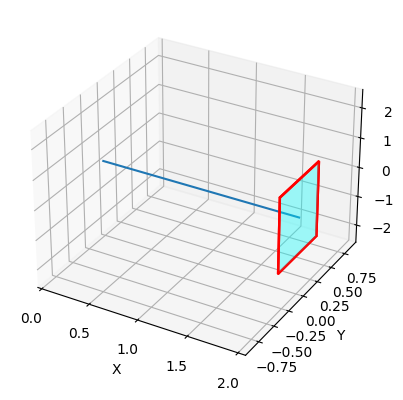

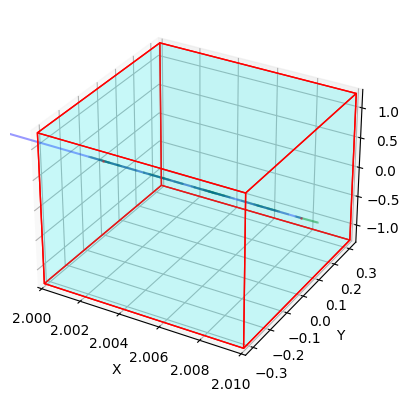

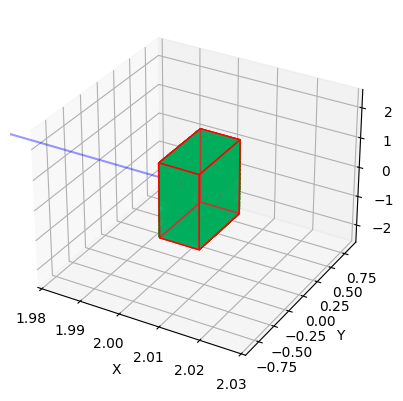

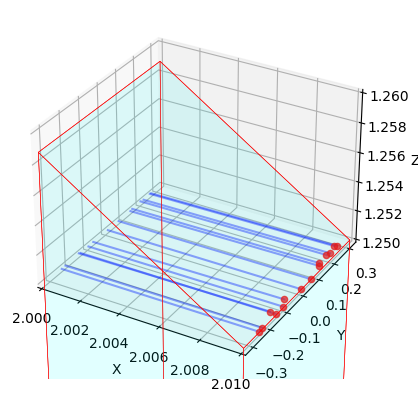

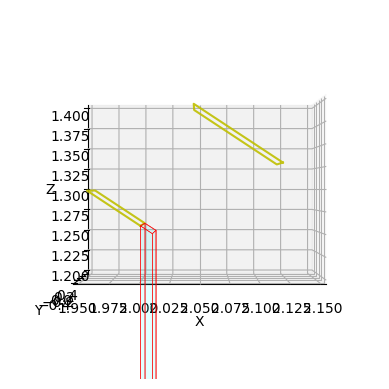

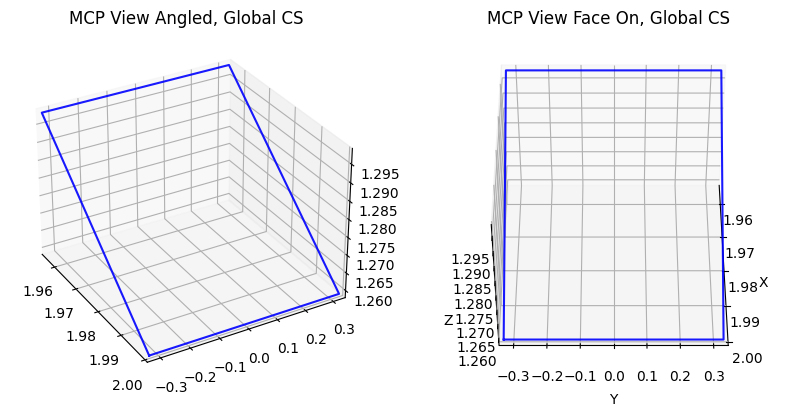

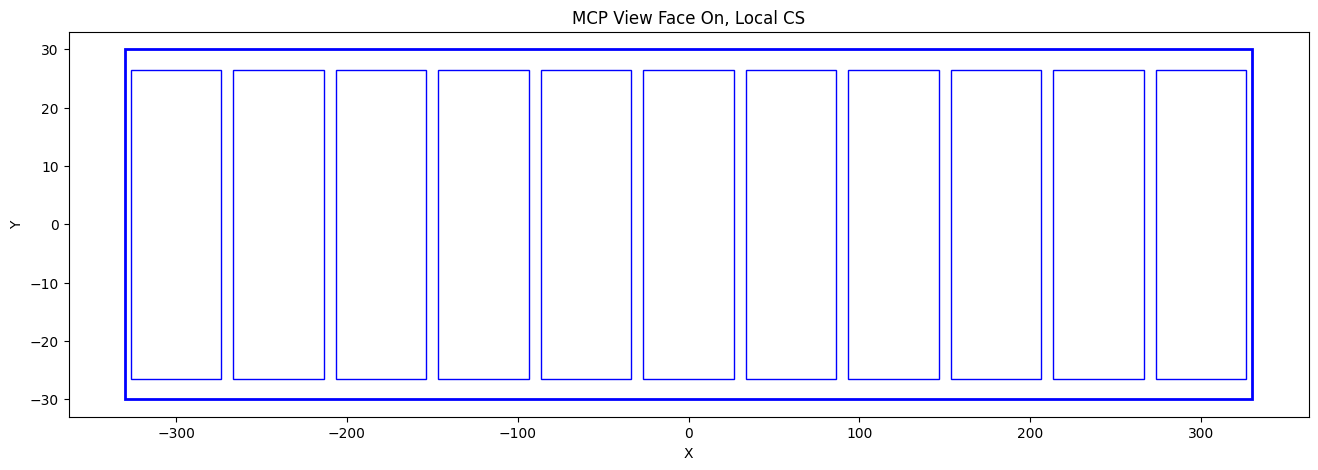

In [329]:
### Visulise the simulation

visulise_tracks(sim_data)

visulise_radiation(sim_data)#, show_radiator=True, show_tracks=True, show_exit_vertex=True)

visulise_quartz(sim_data)#, show_radiator=True, show_tracks=True, show_exit_vertex=True)

visulise_radiator_mouth(sim_data)#, show_tracks=True, show_exit_vertex=True)

visulise_focusing_block(sim_data)#, show_tracks=True, show_exit_vertex=True, show_mouth=True, show_mirror=True, show_MCP=True)

visulise_MCP_global(sim_data)

visulise_MCP_local(sim_data)

# NEW MODULES TESTING (I.E. CURVED MIRROR, CHERENKOV ANGLE, TIR CONDITION, ETC.)

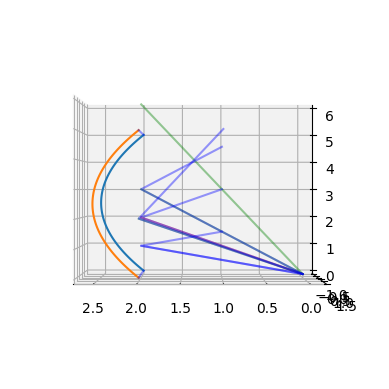

In [330]:
###### CREATING SIMPLE FLAT MIRROR REFLECTION AND CURVED MIRROR VISUALS #####

quartz_depth, quartz_height, quartz_width = quartz_params
qax, qay, qaz = quartz_position


import numpy as np
import matplotlib.pyplot as plt


# Define the corner coordinates
corner_coords = np.array([
    [2, -1, 0],  # Bottom-left corner
    [2, 1, 0],  # Bottom-right corner
    [2, -1, 5],  # Top-right corner
    [2, 1, 5]   # Top-left corner
])


def make_curve(angle_degrees, mirror_position):
    # Convert angle to radians
    angle_radians = np.radians(angle_degrees)

    # Define the corner coordinates
    mir_x, mir_y, mir_z = mirror_position
    theta = np.linspace(-angle_radians, angle_radians, 100)  # Angle in radians
    z = np.linspace(0, mir_z, 100)
    x = np.linspace(mir_x, mir_x, 100) * theta**2
    y = np.linspace(-mir_y, -mir_y, 100)

    # Map x values from range 0 - 20 to range 20 - 0
    max_x = max(x)
    x = -x + max_x + 2
    return x, y, z


# User-specified angle in degrees
angle_degrees = 30

mirror_position = corner_coords[3] # top left corner
x1, y1, z1 = make_curve(angle_degrees, mirror_position)
mirror_position = corner_coords[2] # top right corner
x2, y2, z2 = make_curve(angle_degrees, mirror_position)

x_curve = x1 # x1 and x2 are the same

# Dummy tracks

track1 = np.array([[0, 0, 0], [1, 0, 0.5], [2, 0, 1]])
track2 = np.array([[0, 0, 0], [1, 0, 1], [2, 0, 2]])
track3 = np.array([[0, 0, 0], [1, 0, 1.5], [2, 0, 3]])
track4 = np.array([[0, 0, 0], [1, 0, 3], [2, 0, 6]])
track5 = np.array([[0, 0, 0], [1, 0.48, 1], [2, 0.96, 2]])

traks = [track1, track2, track3, track4, track5]
directions = np.array([(1, 0, 0.5), (1, 0, 1), (1, 0, 1.5), (1, 0, 3), (1, 0.48, 3)])

reflections = []
for track, direction in zip(traks, directions):
    ref = np.array([(np.nan, np.nan, np.nan)])
    if track[2][1] > -1 and track[2][1] < 1 and track[2][2] > 0 and track[2][2] < 5:
        #print("hit")
        direction[0] *= -1 # reflect in x direction
        #print(direction)

        # from the last point of the track, propegate in the new direction
        ref = np.vstack((track, track[-1] + direction))

    else:
        #print("no hit")
        pass
    reflections.append(ref)



fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# PLOT MIRROR curves
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)

#PLOT LINES BETWEEN first two corner coordinates
ax.plot([corner_coords[0][0], corner_coords[1][0]],
        [corner_coords[0][1], corner_coords[1][1]],
        [corner_coords[0][2], corner_coords[1][2]], c='b', alpha=0.4)

# plot line between last two corner coordinates
ax.plot([corner_coords[2][0], corner_coords[3][0]],
        [corner_coords[2][1], corner_coords[3][1]],
        [corner_coords[2][2], corner_coords[3][2]], c='b', alpha=0.4)

# Plot tracks
ax.plot(track1[:, 0], track1[:, 1], track1[:, 2], c='b', alpha=0.4, label=f"Track 1")
ax.plot(track2[:, 0], track2[:, 1], track2[:, 2], c='r', alpha=0.4, label=f"Track 2")
ax.plot(track3[:, 0], track3[:, 1], track3[:, 2], c='g', alpha=0.4, label=f"Track 3")
ax.plot(track4[:, 0], track4[:, 1], track4[:, 2], c='g', alpha=0.4, label=f"Track 4")
ax.plot(track5[:, 0], track5[:, 1], track5[:, 2], c='g', alpha=0.4, label=f"Track 5")

# plot reflections
for reflection_val in reflections:
    ax.plot(reflection_val[:, 0], reflection_val[:, 1], reflection_val[:, 2], c='b', alpha=0.4, label=f"Track 1")
    
ax.view_init(azim=90, elev=0)
plt.show()

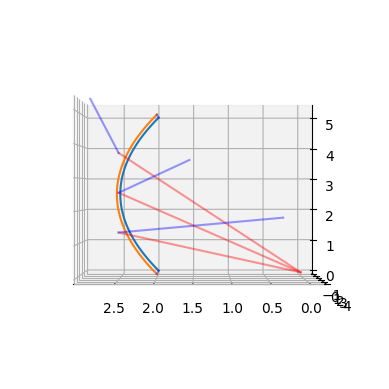

In [331]:
##### ADDING CURVATURE OF MIRROR TO REFLECTION SIMULATION #####

quartz_depth, quartz_height, quartz_width = quartz_params
qax, qay, qaz = quartz_position


def make_curve(angle_degrees, mirror_position):
    angle_radians = np.radians(angle_degrees)
    mir_x, mir_y, mir_z = mirror_position

    theta = np.linspace(-angle_radians, angle_radians, 100)
    z = np.linspace(0, mir_z, 100)
    x = -mir_x * theta**2 + max(mir_x * theta**2) + 2
    y = np.full(100, -mir_y)

    return x, y, z

# Define the corner coordinates
corner_coords = np.array([
    [2, -1, 0],  # Bottom-left corner
    [2, 1, 0],  # Bottom-right corner
    [2, -1, 5],  # Top-right corner
    [2, 1, 5]   # Top-left corner
])


def calculate_x(angle_degrees, mirror_position, target_z):
    angle_radians = np.radians(angle_degrees)
    mir_x, _, mir_z = mirror_position

    theta = np.linspace(-angle_radians, angle_radians, 10000)   ##### THIS 10000 will make it slow?!?!? parmaterise
    z = np.linspace(0, mir_z, 10000)           ##### THIS 10000 will make it slow?!?!? parmaterise
    
    # find the index of the z value closest to the target z
    idx = (np.abs(z - target_z)).argmin()

    # calculate the theta value at that index
    theta_at_idx = theta[idx]
    
    x = -mir_x * theta_at_idx**2 + (mir_x * theta_at_idx**2) + 2

    return x





# User-specified angle in degrees
angle_degrees = 30

mirror_position = corner_coords[3] # top left corner
x1, y1, z1 = make_curve(angle_degrees, mirror_position)
mirror_position = corner_coords[2] # top right corner
x2, y2, z2 = make_curve(angle_degrees, mirror_position)

back_of_mirror_curve_coord = max(x1) # x1 and x2 are the same

# Dummy tracks

track1 = np.array([0,0,0])
track2 = np.array([0,0,0])
track3 = np.array([0,0,0])
track4 = np.array([0,0,0])
track5 = np.array([0,0,0])


traks = [track1, track2, track3, track4, track5]
directions = np.array([(1, 0, 0.5), (1, 0, 1), (1, 0, 1.5), (1, 0, 3), (1, 0.48, 3)])
mirror_intersections = []
reflections = []

for position, direction in zip(traks, directions):
    ref = np.array([(np.nan, np.nan, np.nan)])
    intersection_point = (np.nan, np.nan, np.nan)

    # Update the track's position based on the direction vector to a x coordinate greater than the rear of the mirror's curved surface (back_of_mirror_curve_coord)
    position = position + direction * (back_of_mirror_curve_coord)# - position[0])

    # Extract position coordinates
    x, y, z = position
    x_at_pos = calculate_x(angle_degrees, mirror_position, z)
    
    # Check if the track has intersected with the mirror's curved surface
    if y >= corner_coords[0][1] and y <= corner_coords[1][1] and z >= corner_coords[0][2] and z <= corner_coords[2][2] and x >= x_at_pos:
        intersection_point = position
        #print("hit")
        # Store the intersection point in the reflections list
        
        direction[0] *= -1 # reflect in x direction
        # from the last point of the track, propegate in the new direction
        ref = np.vstack((position, position[-1] + direction))
        
    else:
        #print("no hit")
        pass
    
    mirror_intersections.append(intersection_point)
    reflections.append(ref)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# PLOT MIRROR curves
ax.plot(x1, y1, z1)
ax.plot(x2, y2, z2)

#PLOT LINES BETWEEN first two corner coordinates
ax.plot([corner_coords[0][0], corner_coords[1][0]],
        [corner_coords[0][1], corner_coords[1][1]],
        [corner_coords[0][2], corner_coords[1][2]], c='b', alpha=0.4)

# plot line between last two corner coordinates
ax.plot([corner_coords[2][0], corner_coords[3][0]],
        [corner_coords[2][1], corner_coords[3][1]],
        [corner_coords[2][2], corner_coords[3][2]], c='b', alpha=0.4)

# Plot lines from track to intersection point for each track and interation point pair
for track, intersection_point in zip(traks, mirror_intersections):
    ax.plot([track[0], intersection_point[0]],
            [track[1], intersection_point[1]],
            [track[2], intersection_point[2]], c='r', alpha=0.4)

# plot reflections
for reflection_val in reflections:
    ax.plot(reflection_val[:, 0], reflection_val[:, 1], reflection_val[:, 2], c='b', alpha=0.4, label=f"Track 1")
    
ax.view_init(azim=90, elev=0)
plt.show()


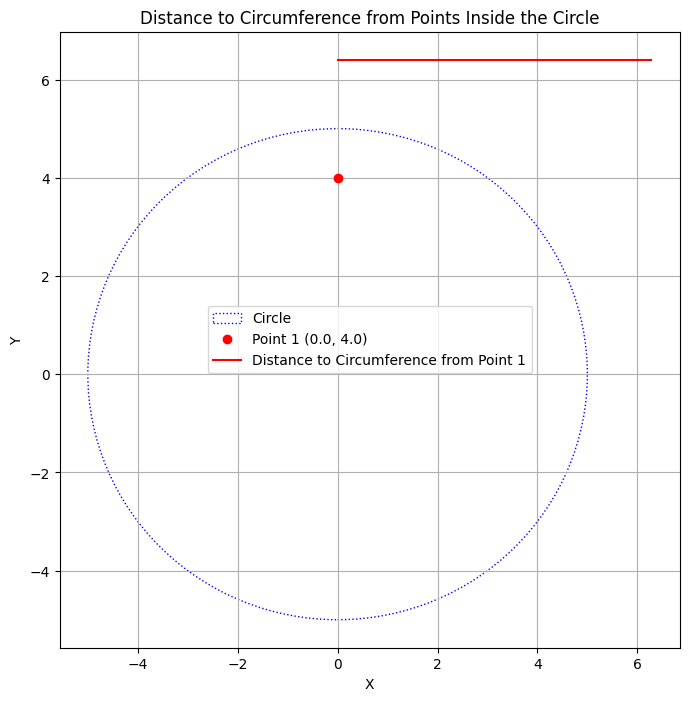

In [332]:
def distance_to_circumference(x, y, r, theta):
    if x == 0:
        if y > 0:
            phi = np.pi / 2  # 90 degrees
        elif y < 0:
            phi = -np.pi / 2  # -90 degrees
        else:
            return r  # (0, 0) is the center of the circle

    if y == 0:
        if x > 0:
            phi = 0
        elif x < 0:
            phi = np.pi
        else:
            return r

    else:
        phi = np.arctan2(y, x)
    
    distance = np.sqrt(x**2 + y**2 - 2 * x * y * np.sin(theta - phi) + r**2)
    return distance

# Test cases
x_values = [0.0]
y_values = [4.0]
r = 5.0  # Radius of the circle

# Create a visualization
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), r, fill=False, color='blue', linestyle='dotted', label='Circle')
ax.add_patch(circle)

for i in range(len(x_values)):
    x = x_values[i]
    y = y_values[i]
    theta = np.linspace(0, 2 * np.pi, 100)  # Create a range of angles
    distances = [distance_to_circumference(x, y, r, t) for t in theta]
    plt.plot(x, y, 'ro', label=f'Point {i + 1} ({x}, {y})')
    plt.plot([], [], 'r-', label=f'Distance to Circumference from Point {i + 1}')
    plt.plot(theta, distances, 'r-')

#plt.xlim(-r - 1, r + 1)
#plt.ylim(-r - 1, r + 1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distance to Circumference from Points Inside the Circle')
plt.legend()
plt.grid(True)
plt.show()


In [333]:
def shortest_distance_to_circle(x1, y1, h, k, r):
    distance = abs(np.sqrt((x1 - h) ** 2 + (y1 - k) ** 2) - r)
    return distance

# Example usage:
x1 = 0  # x-coordinate of the point
y1 = 6  # y-coordinate of the point
h = 0   # x-coordinate of the circle center
k = 0   # y-coordinate of the circle center
r = 5   # radius of the circle

distance = shortest_distance_to_circle(x1, y1, h, k, r)
print("Shortest distance between the point and circle:", distance)


Shortest distance between the point and circle: 1.0


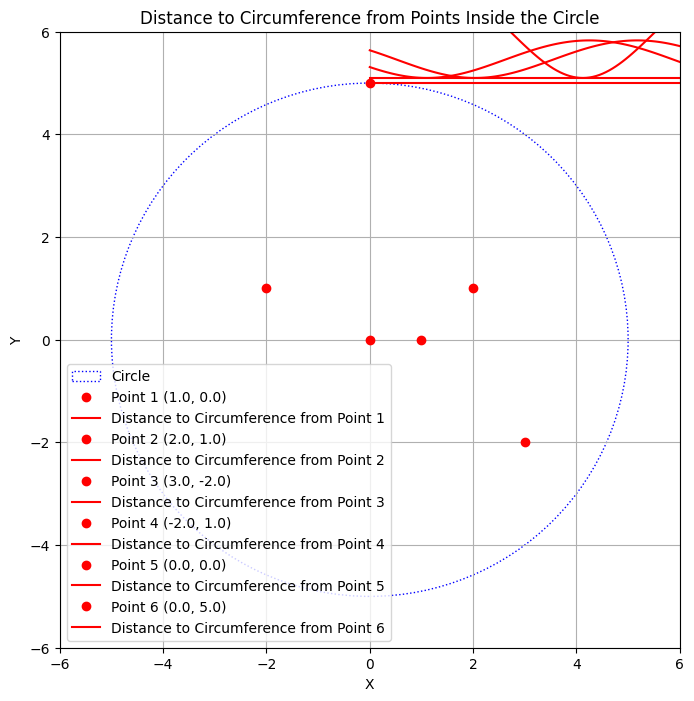

In [334]:
def distance_to_circumference(x, y, r, theta):
    if x == 0:
        if y > 0:
            phi = np.pi / 2  # 90 degrees
        elif y < 0:
            phi = -np.pi / 2  # -90 degrees
        else:
            return r  # (0, 0) is the center of the circle

    if y == 0:
        if x > 0:
            phi = 0
        elif x < 0:
            phi = np.pi
        else:
            return r

    else:
        phi = np.arctan2(y, x)
    
    distance = np.sqrt(x**2 + y**2 - 2 * x * y * np.sin(theta - phi) + r**2)
    return distance

# Test cases
x_values = [1.0, 2.0, 3.0, -2.0, 0.0, 0.0]
y_values = [0.0, 1.0, -2.0, 1.0, 0.0, 5.0]
r = 5.0  # Radius of the circle

# Create a visualization
fig, ax = plt.subplots(figsize=(8, 8))
circle = plt.Circle((0, 0), r, fill=False, color='blue', linestyle='dotted', label='Circle')
ax.add_patch(circle)

for i in range(len(x_values)):
    x = x_values[i]
    y = y_values[i]
    theta = np.linspace(0, 2 * np.pi, 100)  # Create a range of angles
    distances = [distance_to_circumference(x, y, r, t) for t in theta]
    plt.plot(x, y, 'ro', label=f'Point {i + 1} ({x}, {y})')
    plt.plot([], [], 'r-', label=f'Distance to Circumference from Point {i + 1}')
    plt.plot(theta, distances, 'r-')

plt.xlim(-r - 1, r + 1)
plt.ylim(-r - 1, r + 1)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Distance to Circumference from Points Inside the Circle')
plt.legend()
plt.grid(True)
plt.show()


In [335]:
def calculate_square_side_lengths(qax, qay, qaz, half_quartz_width, half_quartz_height):
    # Define the four corners of the square
    corners = np.array([
        [qax, qay - half_quartz_width, qaz + half_quartz_height + 0.03],  # Bottom-left corner
        [qax, qay + half_quartz_width, qaz + half_quartz_height + 0.03],  # Bottom-right corner
        [qax - 0.04, qay + half_quartz_width, qaz + half_quartz_height + 0.08],  # Top-right corner
        [qax - 0.04, qay - half_quartz_width, qaz + half_quartz_height + 0.08]  # Top-left corner
    ])

    # Calculate the length of each side
    side_lengths = []
    for i in range(4):
        next_index = (i + 1) % 4  # Wrap around to the first point for the last side
        side_length = np.linalg.norm(corners[next_index] - corners[i])
        side_lengths.append(side_length)

    return side_lengths
"""
# Example usage:
qax, qay, qaz = quartz_position
quartz_depth, quartz_height, quartz_width = quartz_params
half_quartz_width = quartz_width / 2
half_quartz_height = quartz_height / 2

side_lengths = calculate_square_side_lengths(qax, qay, qaz, half_quartz_width, half_quartz_height)
print("Length of each side of the square:", side_lengths)
"""

'\n# Example usage:\nqax, qay, qaz = quartz_position\nquartz_depth, quartz_height, quartz_width = quartz_params\nhalf_quartz_width = quartz_width / 2\nhalf_quartz_height = quartz_height / 2\n\nside_lengths = calculate_square_side_lengths(qax, qay, qaz, half_quartz_width, half_quartz_height)\nprint("Length of each side of the square:", side_lengths)\n'

In [336]:
    def critical_angle_snells_law(self, n1, n2):
        """
        Calculate the critical angle for total internal reflection.
        
        Args:
        n1 (float): Refractive index of the first medium.
        n2 (float): Refractive index of the second medium.
        
        Returns:
        float: The critical angle in degrees.
        """     
        # Calculate the critical angle in radians using Snell's Law.
        critical_angle_rad = np.arcsin(n2 / n1)  # changgy to nunpy aSIN
        
        # Convert the angle from radians to degrees.
        critical_angle_deg = np.degrees(critical_angle_rad)   #change to numpy function
        
        return critical_angle_deg